In [1]:
import sys
sys.path.append('../popalign/')
import popalign as PA
import importlib

In [2]:
PA.__file__

'../popalign/popalign.py'

In [23]:
# Load data (example)
importlib.reload(PA)
LOAD = 'screen'

# Load samples from distinct matrix files
if LOAD == 'samples':
    mysamples = {
        'CTRL' : '../data/samples/PBMC.mtx',
        'GMCSF_1ng/ml' : '../data/samples/GMCSF.mtx',
        'IFNG_1ng/ml' : '../data/samples/IFNG.mtx',
        'IL2_10ng/ml' : '../data/samples/IL2.mtx',
        'CD40L_20ng/ml' : '../data/samples/CD40L.mtx',
    }
    mygenes = '../data/samples/genes.tsv'
    pop = PA.load_samples(samples=mysamples, 
                          genes=mygenes,
                          outputfolder='output_samples')
    
# Load samples from one matrix file with metadata (must include cell_barcode, sample_id columns)
elif LOAD == 'screen':
    #mymatrix = '../data/screen/drug_screen/pbmcmult4cd3minus.mtx'
    #mybarcodes = '../data/screen/drug_screen/barcodes.tsv'
    #mygenes = '../data/screen/drug_screen/features.tsv'
    #mymetadata = '../data/screen/drug_screen/meta.csv'
    mymatrix = '../data/screen/PBMC-MULT-6/PBMC-MULT-6.mtx'
    mybarcodes = '../data/screen/PBMC-MULT-6/barcodes.tsv'
    mygenes = '../data/screen/PBMC-MULT-6/genes.tsv'
    mymetadata = '../data/screen/PBMC-MULT-6/updated_meta.csv'
    pop = PA.load_screen(matrix=mymatrix, 
                         barcodes=mybarcodes, 
                         metafile=mymetadata, 
                         genes=mygenes,
                         outputfolder='output_screen',
                         only=[], # list of sample names to only load the specified samples
                         col='CD3', # either None or a column name from the meta data
                         value=1) # if col != None, specify value in column to filter samples

In [26]:
# Perform column normalization
# Find best normalization factor
PA.normalize(pop, scaling_factor=None)

Performing column normalization
Finding best scaling factor


1741 genes selected


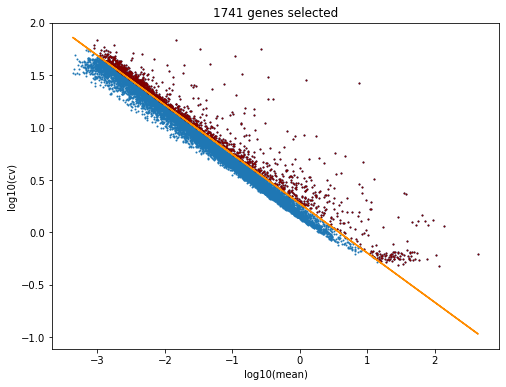

In [28]:
# Plot genes (log cv ~ log cv) and filtering line --use multiple times to find best offset (usually between .7 and 1.5)
PA.plot_gene_filter(pop, offset=1.15)

In [29]:
# Gene filter the data with the last offset value used in the previous step
PA.filter(pop, remove_ribsomal=True)

Removing ribosomal genes
Filtering genes ang logging data


In [ ]:
# Remove red blood cells from the data
PA.removeRBC(pop, species='human')

In [30]:
# Generate multiple feature spaces and pick the best one based on reconstruction error
# Run GSEA on each feature
# Generate QC plots
PA.onmf(pop, ncells=5000, nfeats=[5,7], nreps=3, niter=500)

Computing W matrices
......... Iteration #0
......... Iteration #0
......... Iteration #0
......... Iteration #0
......... Iteration #0
......... Iteration #0
......... Iteration #100
......... Iteration #100
......... Iteration #100
......... Iteration #100
......... Iteration #100
......... Iteration #100
......... Iteration #200
......... Iteration #200
......... Iteration #200
......... Iteration #200
......... Iteration #200
......... Iteration #200
......... Iteration #300
......... Iteration #300
......... Iteration #300
......... Iteration #300
......... Iteration #300
......... Iteration #300
......... Iteration #400
......... Iteration #400
......... Iteration #400
......... Iteration #400
......... Iteration #400
......... Iteration #400
......... Iteration #499
......... Iteration #499
Orthogonal NMF performed with 500 iterations

Orthogonal NMF performed with 500 iterations
......... Iteration #499

Orthogonal NMF performed with 500 iterations

......... Iteration #499
...

In [31]:
# Build a Gaussian Mixture model for each sample
# Type the models subpopulations
PA.build_gmms(pop, 
              ks=(5,8), 
              niters=3, 
              training=.8, 
              nreplicates=2,
              reg_covar=True, 
              rendering='grouped', 
              types='defaultpbmc', # either None, 'defaultpbmc' or a dictionary
              figsizegrouped=(20,20),
              figsizesingle=(6,5))

Building model for Betamethasone Valerate_CD3 (1 of 43)
Building model for Mesalamine_CD3 (2 of 43)
Building model for CONTROL_CD3 (3 of 43)
Building model for Meprednisone_CD3 (4 of 43)
Building model for Alprostadil_CD3 (5 of 43)
Building model for Triamcinolone Acetonide_CD3 (6 of 43)
Building model for Naproxen Sodium_CD3 (7 of 43)
Building model for Thalidomide_CD3 (8 of 43)
Building model for Loratadine_CD3 (9 of 43)
Building model for Doramapimod_CD3 (10 of 43)
Building model for Bimatoprost_CD3 (11 of 43)
Building model for Etodolac_CD3 (12 of 43)
Building model for Loteprednol etabonate_CD3 (13 of 43)
Building model for Zileuton_CD3 (14 of 43)
Building model for Cetirizine DiHCl_CD3 (15 of 43)
Building model for Tazarotene_CD3 (16 of 43)
Building model for Latrepirdine 2HCl_CD3 (17 of 43)
Building model for Zafirlukast_CD3 (18 of 43)
Building model for Mercaptopurine_CD3 (19 of 43)
Building model for Febuxostat_CD3 (20 of 43)
Building model for Sulfasalazine_CD3 (21 of 43)
Bui

In [ ]:
# If the renderings do not have the right figure size, regenerate the renderings with:
#PA.render_models(pop, figsizegrouped=(20,20), figsizesingle=(6,5), mode='grouped')

In [33]:
# Align subpopulations of each sample against a reference model's subpopulations
PA.align(pop, ref='CONTROL_CD3', method='conservative', figsizedeltas=(10,10), figsizeentropy=(10,10))

In [34]:
# Rank each sample against a reference sample's model
PA.rank(pop, ref='CONTROL_CD3', k=100, niter=200, mincells=50, figsize=(10,5))

In [35]:
# Build a unique GMM for the samples concatenated together
PA.build_unique_gmm(pop, 
                    ks=(5,20), 
                    niters=3, 
                    training=0.2, 
                    reg_covar=True, 
                    types='defaultpbmc', # either None, 'defaultpbmc' or a dictionary
                    figsize=(6,5))

In [38]:
# Generate a query plot
PA.plot_query(pop,  pcells=.2, nreps=10, figsize=(20,100), sharey=False)

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#-------------- WORK IN PROGRESS BELOW ----------------
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [ ]:
importlib.reload(PA)
genelist = [
    'CD14',
    'CD33',
    'LYZ',
    'FCER1G',
    'LGALS3',
    'CSF1R',
    'ITGAX',
    'ITGAM',
    'CD86',
    'HLA-DRB1'
]
PA.plot_heatmap(pop, refcomp=0, genelist=genelist, savename=None, figsize=(15,15), cmap='Purples', samplelimits=True)

In [ ]:
# Interactive 3D visualization of the data in feature space
import plotly
plotly.offline.init_notebook_mode()
PA.plotfeatures(pop)

In [ ]:
import numpy as np
from multiprocessing import Pool
import matplotlib
from matplotlib import pyplot as plt

def l1norm(ig, M1, M2, nbins):
    arr1 = M1[ig,:].toarray() # get gene ig values by idx
    arr2 = M2[ig,:].toarray() # get gene ig values by idx
    max1, max2 = np.max(arr1), np.max(arr2) # get max values from the two subpopulations
    max_ = max(max1,max2) # get max value to define histogram range
    
    b1, be1 = np.histogram(arr1, bins=nbins, range=(0,max_))
    b2, be2 = np.histogram(arr2, bins=nbins, range=(0,max_))
    b1 = b1/len(arr1) # scale bin values
    b2 = b2/len(arr2) # scale bin values
    
    return np.linalg.norm(np.abs(b1-b2))

refcomp = 0
ref = pop['ref']
Mref = pop['samples'][ref]['M']
Cref = pop['samples'][ref]['C']
prediction = pop['samples'][ref]['gmm'].predict(Cref)
idxref = np.where(prediction==refcomp)[0]
Mref = Mref[:,idxref]

qs = []
for i,x in enumerate(pop['order']): # for each sample in pop
    print('Progress: %d of %d' % ((i+1), pop['nsamples']), end='\r')
    if x != ref: # if that sample is not the reference sample
        try: # check if an aligned subpopulation exists for that sample
            arr = pop['samples'][x]['alignments'] # retrive test sample alignments
            irow = np.where(arr[:,1]==refcomp) # get row number in alignments where ref subpop is the desired ref subpop
            itest = int(arr[irow, 0]) # get test subpopulation number if exists

            Ctest = pop['samples'][x]['C'] # get test sample feature space data
            prediction = pop['samples'][x]['gmm'].predict(Ctest) # get the subpopulations assignments
            idx = np.where(prediction==itest)[0] # get indices of cells that match aligned test subpopulation

            Mtest = pop['samples'][x]['M'] # get test sample gene space data, subsample
            Mtest = Mtest[:,idx] # select test subpopulation cells
               
            nbins = 20
            with Pool(None) as p:
                q = p.starmap(l1norm, [(ig, Mref, Mtest, nbins) for ig in range(Mref.shape[0])]) # for each gene idx ig, call the l1norm function
            qs.append(q)
        except:
            pass

In [ ]:
qs

In [ ]:
np.max(qs[0])

In [ ]:
np.vstack(qs)

In [ ]:
gidx = [np.where(pop['genes']==x)[0][0] for x in ['X','X2']]
M = pop['samples']['CTRL']['M'][gidx,]